# Prepare Dataset

In [1]:
!pip install transformers datasets evaluate accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.2 MB/s eta 0:00:00


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhamadalan","key":"3234178b0250039a2aa69d80d9d3cb4c"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d saurabhshahane/ecommerce-text-classification

  0% 0.00/7.86M [00:00<?, ?B/s]
100% 7.86M/7.86M [00:00<00:00, 193MB/s]


In [5]:
!unzip '/content/ecommerce-text-classification.zip' -d '/content/ecommerce-class'

Archive:  /content/ecommerce-text-classification.zip
  inflating: /content/ecommerce-class/ecommerceDataset.csv  


# Import Library

In [6]:
import pandas as pd
import numpy as np

import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Import Dataset

In [7]:
data = pd.read_csv('/content/ecommerce-class/ecommerceDataset.csv', names=['labels', 'texts'])
data = data[['texts', 'labels']]
data.head()

,texts,labels
0,Paper Plane Design Framed Wall Hanging Motivat...,Household
1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",Household
2,SAF 'UV Textured Modern Art Print Framed' Pain...,Household
3,"SAF Flower Print Framed Painting (Synthetic, 1...",Household
4,Incredible Gifts India Wooden Happy Birthday U...,Household


# EDA

In [8]:
data['texts'].iloc[1]

"SAF 'Floral' Framed Painting (Wood, 30 inch x 10 inch, Special Effect UV Print Textured, SAO297) Painting made up in synthetic frame with UV textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch (A perfect gift for your special ones)."

In [9]:
data.shape

(50425, 2)

In [10]:
data.loc[(data['texts'].isna())]

,texts,labels
39330,NaN,Clothing & Accessories


In [11]:
data = data.dropna()

In [12]:
pd.concat([data['labels'].value_counts(), round(data['labels'].value_counts(normalize=True) * 100, 2)], axis=1)

,labels,labels
Household,19313,38.30
Books,11820,23.44
Electronics,10621,21.06
Clothing & Accessories,8670,17.19


<Axes: xlabel='labels'>

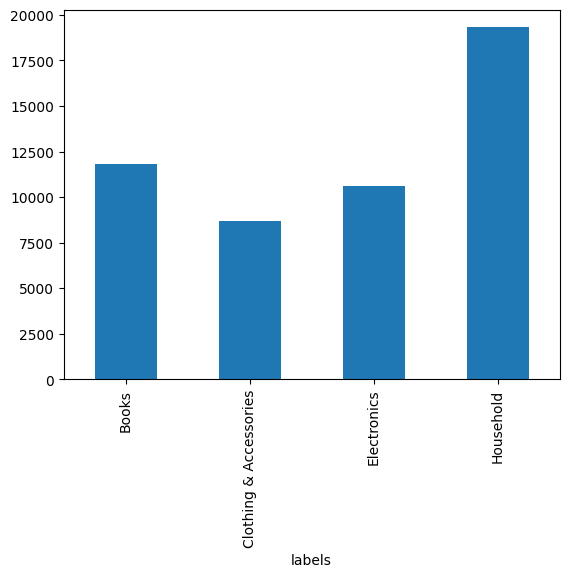

In [13]:
data.groupby('labels').size().plot(kind='bar')

# Preprocessing

In [14]:
encode = {'Household': 0,
          'Books': 1,
          'Clothing & Accessories': 2,
          'Electronics': 3}

data['labels'].replace(encode, inplace=True)

In [15]:
data

,texts,labels
0,Paper Plane Design Framed Wall Hanging Motivat...,0
1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",0
2,SAF 'UV Textured Modern Art Print Framed' Pain...,0
3,"SAF Flower Print Framed Painting (Synthetic, 1...",0
4,Incredible Gifts India Wooden Happy Birthday U...,0
...,...,...
50420,Strontium MicroSD Class 10 8GB Memory Card (Bl...,3
50421,CrossBeats Wave Waterproof Bluetooth Wireless ...,3
50422,Karbonn Titanium Wind W4 (White) Karbonn Titan...,3
50423,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou...",3


In [16]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [17]:
from datasets import Dataset
def preprocess_function(text):
    return tokenizer(text['texts'], truncation=True, padding=True, return_tensors='pt')

dataset = Dataset.from_pandas(data).train_test_split(test_size=0.1)
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/45381 [00:00<?, ? examples/s]

Map:   0%|          | 0/5043 [00:00<?, ? examples/s]

# Evaluate

In [18]:
  from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [19]:
import evaluate
accuracy = evaluate.load("accuracy")

In [20]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# Train

In [21]:
id2label = {0: 'Household',
          1: 'Books',
          2: 'Clothing & Accessories',
          3: 'Electronics'}
label2id = {'Household': 0,
          'Books': 1,
          'Clothing & Accessories': 2,
          'Electronics': 3}

In [22]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=4, id2label=id2label, label2id=label2id
)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    # push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.136700,0.115495,0.970256


Epoch,Training Loss,Validation Loss,Accuracy
1,0.136700,0.115495,0.970256
2,0.071400,0.094358,0.978981


TrainOutput(global_step=5674, training_loss=0.1289456172186092, metrics={'train_runtime': 4452.1676, 'train_samples_per_second': 20.386, 'train_steps_per_second': 1.274, 'total_flos': 1.2023434863304704e+16, 'train_loss': 0.1289456172186092, 'epoch': 2.0})

In [86]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, pipeline

# Replace with your custom model of choice
model_name = '/content/my_awesome_model/checkpoint-5674'
model = DistilBertForSequenceClassification.from_pretrained(model_name)
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

classifier = pipeline(task='text-classification',  # replace with whatever task you have
                model=model,
                tokenizer=tokenizer)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.


# Test

In [97]:
import random

# Ambil 10 indeks unik secara acak dari dataset test
random_indices = random.sample(range(len(dataset['test']['texts'])), 5)

# Tampilkan 10 teks dan labelnya
for index in random_indices:
    text_to_evaluate = dataset['test']['texts'][index]
    true_label_id = dataset['test']['labels'][index]
    true_label = id2label[true_label_id]

    truncated_text = text_to_evaluate[:512]

    # Predict the class
    predicted_label = classifier(text_to_evaluate)

    print("Text:", truncated_text)
    print("True Label:", true_label)
    print("Predicted Label:", predicted_label)
    print("----------------")

Text: Ramkuwar International Silicone Cooking Tongs，Kitchen Food Tongs，Stainless Steel Material with Heat Resistant Premium Silicone Grip for BBQ Grilling Turner Cooking Tips, 9" Inch (Black) Color Name:BLACK   "P-PLUS INTERNATIONAL cooking tongs are made of premium silicone and strong stainless steel frames, giving you great grip and control when handling food. And they protect your food and safe for your family. Let's enjoy the fun of cooking!   Advantage： 1. 9 inch tongs most meet your requirements indoor and 
True Label: Household
Predicted Label: [{'label': 'Household', 'score': 0.998606264591217}]
----------------
Text: AM Acrylic Sewing Travel Kit Sewing threads with all supplies for multipurpose use.A must item in everybody's home. Can sew anything from last minute buttons or beautiful patches. 24 different colors according to need. Superior quality thread with all sewing supplies. A perfect last minute travel kit with everything in a beautiful thread box. This kit includes- 24